In [1]:
import sys
sys.path.append('../../libmitigation')

In [2]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
from qiskit.result import Result
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *
from qiskit.compiler import transpile

In [4]:
# import lib_grover
# importlib.reload(lib_grover)
# from lib_grover import *

### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [5]:
import math

b_max = math.pi / 100  # upper limit of integral # 5
nbit = 3  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2 ** nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 0.00032892188007938847
Discretized Result: 0.0003276376184271807


For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


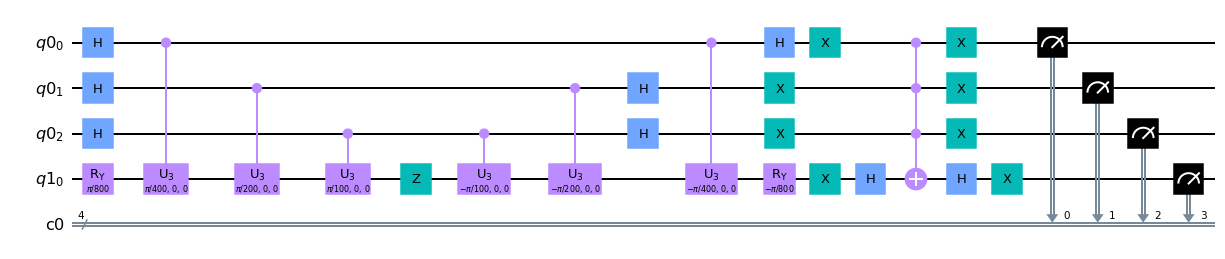

In [6]:
qc_list = create_grover_circuit([1], nbit, b_max, barrier=False)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [7]:
#setting the number of shots and Grover operators.

# number_grover_list = [0, 1, 2, 4, 8, 16, 32] # , 64, 128, 256]  # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots = 100
shots_list = [shots] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [8]:
qc_list = create_grover_circuit(number_grover_list, nbit, b_max, barrier=False)  # list of Grover circuits

## real device

In [9]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
print(provider)

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


In [10]:
device = provider.backends.ibm_kawasaki

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  """Entry point for launching an IPython kernel.


In [11]:
initial_layout = [10,13,15,12]

In [12]:
optim1_qc_list = [transpile(qc,
                           basis_gates=['u1','u2','u3','cx'], 
                           coupling_map=[[0,3],[1,3],[2,3]], 
                           optimization_level=1) for qc in qc_list]

In [13]:
optim2_qc_list = [transpile(qc,
                           basis_gates=['u1','u2','u3','cx'], 
                           coupling_map=[[0,3],[1,3],[2,3]], 
                           optimization_level=2) for qc in qc_list]

In [14]:
optim3_qc_list = [transpile(qc,
                           basis_gates=['u1','u2','u3','cx'], 
                           coupling_map=[[0,3],[1,3],[2,3]], 
                           optimization_level=3) for qc in qc_list] 

In [22]:
import pickle
with open("qc_list_0to99.pkl", "wb") as f:
    pickle.dump(qc_list, f)

In [23]:
import pickle
with open("optim1_qc_list_0to99.pkl", "wb") as f:
    pickle.dump(optim1_qc_list, f)

In [24]:
import pickle
with open("optim2_qc_list_0to99.pkl", "wb") as f:
    pickle.dump(optim2_qc_list, f)

In [18]:
import pickle
with open("optim3_qc_list_0to99.pkl", "wb") as f:
    pickle.dump(optim3_qc_list, f)

In [12]:
import pickle
with open("optim1_qc_list_0to99.pkl", "rb") as f:
    optim1_qc_list = pickle.load(f)
with open("optim2_qc_list_0to99.pkl", "rb") as f:
    optim2_qc_list = pickle.load(f)
with open("optim3_qc_list_0to99.pkl", "rb") as f:
    optim3_qc_list = pickle.load(f)

In [13]:
print(optim1_qc_list[1].depth(), optim1_qc_list[1].count_ops())
print(optim2_qc_list[1].depth(), optim2_qc_list[1].count_ops())
print(optim3_qc_list[1].depth(), optim3_qc_list[1].count_ops())

69 OrderedDict([('cx', 35), ('u2', 23), ('u3', 19), ('u1', 9), ('measure', 4), ('barrier', 1)])
76 OrderedDict([('cx', 38), ('u2', 29), ('u3', 21), ('u1', 8), ('measure', 4), ('barrier', 1)])
66 OrderedDict([('cx', 32), ('u2', 24), ('u3', 18), ('u1', 16), ('measure', 4), ('barrier', 1)])


In [14]:
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')

In [15]:
job = execute(optim3_qc_list[:50] + meas_calibs, backend=provider.get_backend("ibm_kawasaki"), shots=shots, initial_layout=initial_layout)
print(job.job_id())

61005e78be5079bce72b29bf


In [16]:
counts_list_real = job.result().get_counts()[:-2]
hit_list_real = make_hit_list(counts_list_real)
print(hit_list_real)

[94, 43, 17, 13, 11, 6, 9, 4, 7, 5, 8, 7, 6, 5, 3, 3, 9, 7, 4, 4, 8, 4, 4, 3, 7, 3, 8, 4, 3, 7, 6, 5, 2, 4, 1, 4, 3, 4, 2, 7, 5, 5, 9, 5, 4, 4, 2, 5, 4, 3]


In [17]:
cal_results = Result(backend_name=job.result().backend_name,
                     backend_version=job.result().backend_version,
                     qobj_id=job.result().qobj_id,
                     job_id=job.result().job_id,
                     success=job.result().success,
                     results=job.result().results[-2:])
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [18]:
meas_fitter.cal_matrices

[array([[0.95, 0.03],
        [0.05, 0.97]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[0.97, 0.  ],
        [0.03, 1.  ]])]

## Mitigation

In [19]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = []
for counts in counts_list_real:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

changed identity matrix into negative Hadamard matrix at mit_pattern[ 1 ]
changed identity matrix into negative Hadamard matrix at mit_pattern[ 2 ]
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0320484087852984
sum of mitigated probability vector x_hat_s: 1.0249393317092417
0.002032041549682617 s
number of positive values:  3
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0043478260869567
sum of mitigated probability vector x_hat_s: 0.9816255632252816
0.0029659271240234375 s
number of positive values:  13
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0000000000000002
sum of mitigated probability vector x_hat_s: 0.9916584491259524
0.004587888717651367 s
number of positive values:  16
accum

In [20]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list_real:
    x_tilde = meas_filter.apply(counts, threshold=1/100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney100_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney100_list)

changed identity matrix into negative Hadamard matrix at mit_pattern[ 1 ]
changed identity matrix into negative Hadamard matrix at mit_pattern[ 2 ]
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0203944419542808, 2: 0.010869565217391306, 4: 0.010869565217391306}
sum of counts: 1.0421335723890635
0.000827789306640625 s
number of positive values:  3
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.4640295831465711, 1: 0.0823621694307486, 2: 0.05434782608695653, 4: 0.1627073061407441, 6: 0.0207306140744061, 7: 0.03081577767817123, 8: 0.04738346033168979, 9: 0.05622478709099059, 12: 0.03696660690273419, 15: 0.029510309278350515}
sum of counts: 0.9850784401613629
0.0005500316619873047 s
number of positive values:  10
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.1831017480950247, 1: 0.04370237561631558, 2: 0.05300313760645452, 3: 0.03978036754818468, 4: 0.04

In [21]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list_real:
    x_tilde = meas_filter.apply(counts, threshold=1/10)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney10_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney10_list)

changed identity matrix into negative Hadamard matrix at mit_pattern[ 1 ]
changed identity matrix into negative Hadamard matrix at mit_pattern[ 2 ]
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0203944419542808}
sum of counts: 1.0203944419542808
0.0005130767822265625 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.4640295831465711, 4: 0.1627073061407441}
sum of counts: 0.6267368892873152
0.00043082237243652344 s
number of positive values:  2
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.1831017480950247, 8: 0.11907216494845357, 12: 0.11467391304347826}
sum of counts: 0.4168478260869566
0.0003352165222167969 s
number of positive values:  3
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.13928731510533396, 2: 0.107350963

Text(0, 0.5, 'number of shots for $|00...0>$')

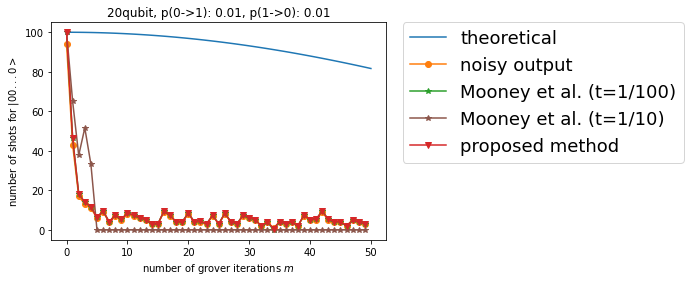

In [27]:
divide = 50
plt.clf()
plt.plot(np.linspace(0,number_grover_list[50], divide), shots * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical")
plt.plot(number_grover_list[:50], hit_list_real, marker="o", label="noisy output")
plt.plot(number_grover_list[:50], mit_hit_mooney100_list, marker="*", label="Mooney et al. (t=1/100)", color="C2")
plt.plot(number_grover_list[:50], mit_hit_mooney10_list, marker="*", label="Mooney et al. (t=1/10)", color="C5")
plt.plot(number_grover_list[:50], mit_hit_S_lm_0_list, marker="v", label="proposed method", color="C3")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("20qubit, p(0->1): 0.01, p(1->0): 0.01")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

In [28]:
sin_hit_list = [shots - h for h in hit_list_real]
sin_mit_hit_S_lm_0_list = [shots - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney100_list = [shots - h for h in mit_hit_mooney100_list]
sin_mit_hit_mooney10_list = [shots - h for h in mit_hit_mooney10_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney100_list = calculate_theta(
    sin_mit_hit_mooney100_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney10_list = calculate_theta(
    sin_mit_hit_mooney10_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney100_list = np.abs(np.sin(thetaCandidate_mit_mooney100_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney10_list = np.abs(np.sin(thetaCandidate_mit_mooney10_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

IndexError: list index out of range

In [ ]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p2 = plt.loglog( OracleCall_list, error_mit_mooney100_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)
p4 = plt.loglog( OracleCall_list, error_mit_mooney10_list, 'x', color='C5', markersize=4)

plt.title("10qubit, p(0|1)=p(1|0)=0.01, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p4[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "Mooney et al. (t=1/10)", "Mooney et al. (t=1/100)", "proposed method"))
plt.show()

## Simulator

In [8]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.990, 0.010],[0.010,0.990]])
        noise_model.add_readout_error(read_err, [qi])

In [10]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.6308660507202148 s
1 th round with 1 oracles
0.02333211898803711 s
2 th round with 2 oracles
0.03971505165100098 s
3 th round with 3 oracles
0.052040815353393555 s
4 th round with 4 oracles
0.0699319839477539 s
5 th round with 5 oracles
0.0882267951965332 s
6 th round with 6 oracles
0.0951850414276123 s
7 th round with 7 oracles
0.10271191596984863 s
8 th round with 8 oracles
0.12267804145812988 s
9 th round with 9 oracles
0.12902116775512695 s
10 th round with 10 oracles
0.14684200286865234 s
11 th round with 11 oracles
0.16660094261169434 s
12 th round with 12 oracles
0.27850890159606934 s
13 th round with 13 oracles
0.19129204750061035 s
14 th round with 14 oracles
0.2644641399383545 s
15 th round with 15 oracles
0.39434289932250977 s
16 th round with 16 oracles
0.29990315437316895 s
17 th round with 17 oracles
0.2710740566253662 s
18 th round with 18 oracles
0.2891678810119629 s
19 th round with 19 oracles
0.306643009185791 s


In [11]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[100, 97, 93, 93, 96, 94, 92, 90, 84, 88, 73, 83, 81, 78, 69, 62, 67, 68, 61, 61]
